## MNIST Binary classifier using Evidential Learning
## TODO create a 10 class binary classifier on MPI to run in parallel

In [ ]:
#from mpi4py import MPI
#import numpy as np
#from tensorflow import keras
#from tensorflow.keras import layers
#import keras
#from scipy import ndimage
#import matplotlib.pyplot as plt
#import cv2
#import tensorflow as tf
#from keras import backend as K
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
# import keras  <-- Remove this line
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K # <-- Change this import


from scipy import stats
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss


import warnings
warnings.filterwarnings('ignore')

In [ ]:
digit=2
num_classes=2
input_shape = (28, 28, 1)

#inp = keras.Input(shape=input_shape)

#x = layers.Conv2D(filters=5, kernel_size=(5,5), activation='relu')(inp)
#x = layers.Conv2D(filters=5, kernel_size=(3, 3), activation='relu')(x)
#x = layers.Flatten()(x)
#x = layers.Dense(units=512, activation='relu')(x)
#x = layers.Dense(units=128, activation='relu')(x)
#x = layers.Dense(units=2)(x)

#model = keras.Model(inp, x)

#model.summary()
inp = keras.Input(shape=input_shape)

x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(inp)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(units=512, activation='relu')(x)
x = layers.Dense(units=128, activation='relu')(x)
x = layers.Dense(units=2)(x)
model = keras.Model(inp, x)


In [ ]:
# Source: https://github.com/michaeleh/Evidential-Deep-Learning-to-Quantify-Classification-Uncertainty/blob/main/demo.ipynb

lgamma = tf.math.lgamma
digamma = tf.math.digamma

epochs = [1]

#def KL(alpha, num_classes=10):
def KL(alpha, num_classes=2):
    one = K.constant(np.ones((1,num_classes)),dtype=tf.float32)
    S = K.sum(alpha,axis=1,keepdims=True)

    kl = lgamma(S) - K.sum(lgamma(alpha),axis=1,keepdims=True) +\
    K.sum(lgamma(one),axis=1,keepdims=True) - lgamma(K.sum(one,axis=1,keepdims=True)) +\
    K.sum((alpha - one)*(digamma(alpha)-digamma(S)),axis=1,keepdims=True)

    return kl


def loss_func(y_true, output):
    y_evidence = K.relu(output)
    alpha = y_evidence+1
    S = K.sum(alpha,axis=1,keepdims=True)
    p = alpha / S

    err = K.sum(K.pow((y_true-p),2),axis=1,keepdims=True)
    var = K.sum(alpha*(S-alpha)/(S*S*(S+1)),axis=1,keepdims=True)

    l =  K.sum(err + var,axis=1,keepdims=True)
    l = K.sum(l)


    kl =  K.minimum(1.0, epochs[0]/50) * K.sum(KL((1-y_true)*(alpha)+y_true))
    return l + kl


In [ ]:
import time

######For one digit at a time #################
digit=2
num_classes=2
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

start = time.time()

batch_size = 1024
model.compile(loss=loss_func, optimizer="adam", metrics=['accuracy'])

models = []

import time
start = time.time()
for digit in range(10):
  print(digit)

  #only one digit at a time
  y_train_digit = (y_train == digit)
  y_test_digit = (y_test == digit)

  # convert class vectors to binary class matrices
  y_train_digit = keras.utils.to_categorical(y_train_digit, 2)
  y_test_digit = keras.utils.to_categorical(y_test_digit, 2)
  #should be a different model per digit
  model.fit(x_train, y_train_digit, batch_size=batch_size, epochs=30, verbose=0, validation_split=0.2)
end = time.time()
print(end - start)

0
1
2
3
4
5
6
7
8
9
734.8988962173462


In [ ]:
score = model.evaluate(x_test, y_test_digit, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Test loss: 0.34266290068626404
Test accuracy: 0.9941999912261963


In [ ]:
def calc_prob_uncertainty(p):

    evidence = np.maximum(p, 0)

    alpha = evidence + 1

    u = 10/ alpha.sum()
    prob = alpha[np.argmax(alpha)] / alpha.sum()
    return prob, u

In [ ]:
y_pred1 = model.predict(x_test)
y_pred =  np.argmax(y_pred1,axis=1)
#y_test_digit=np.argmax(y_test_digit,axis=1)
print(y_pred1)
print(y_test_digit)
print(y_pred)
# Separating Wrong Responses of the CNN Classifier
X_test_wrong, y_test_wrong = x_test[np.where(y_test_digit != y_pred)], y_test_digit[np.where(y_test_digit != y_pred)]

# Separating Correct Responses of the CNN Classifier
X_test_correct, y_test_correct = x_test[np.where(y_test_digit == y_pred)], y_test_digit[np.where(y_test_digit == y_pred)]

r = 0
N = 0
E_F = np.zeros(2)

for ii in range(2):
    X_test_wrong_i, y_test_wrong_i = X_test_wrong[np.where(y_test_wrong == ii+1)], y_test_wrong[np.where(y_test_wrong == ii+1)]
    X_test_correct_i, y_test_correct_i = x_test[np.where(y_test_correct == ii+1)], y_test_digit[np.where(y_test_correct == ii+1)]
    r = X_test_wrong_i.shape[0]
    N = X_test_wrong_i.shape[0] + X_test_correct_i.shape[0]

    E_F[ii] = (1 + r)/(1+1+N)

Reliability = 1 - 0.1*(sum(E_F))

# Calc brier score

mean_bs = np.mean((y_pred - y_test_digit) ** 2)
print(Reliability)
print(f"Mean Brier score: {mean_bs}")
end = time.time()
print(end - start)

313/313 [==============================] - 1s 4ms/step
[[ 557.45374 -474.81244]
 [1208.2292  -905.5315 ]
 [ 398.83853 -254.10611]
 ...
 [ 122.20566  -97.29724]
 [ 354.3876  -289.88632]
 [ 572.1447  -400.4027 ]]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
0.9459446092977251
Mean Brier score: 0.0058
2350.2031667232513


In [ ]:
probs = []
uncs = []
preds = []

for pred in y_pred1:
  p, u = calc_prob_uncertainty(pred)

  probs.append(p)
  uncs.append(u)
  preds.append(np.argmax(pred))

Actual: 2
Predicted: 0
Probability: 0.9991737008094788
Uncertainty: 0.008262897311512238


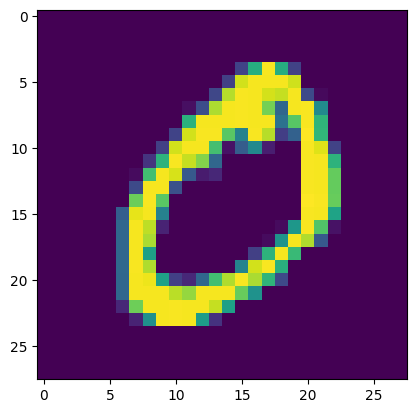

In [ ]:
idx = 1
plt.imshow(x_test[idx][:,:])
print(f'Actual: {y_test[idx]}')
print(f'Predicted: {preds[idx]}') # since is a binary classifier it should say no is not a 2
print(f'Probability: {probs[idx]}')
print(f'Uncertainty: {uncs[idx]}')

some_digit = x_train[idx]
some_digit_show = plt.imshow(x_train[idx].reshape(28,28))
#int(y_train_digit_cp[idx])